using vader, roberta pretrained model and hugging face pipeline

Import data and NLTK basics

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import random
import nltk
nltk.download('punkt')  # Ensure the standard punkt tokenizer is installed
nltk.download('averaged_perceptron_tagger')  # Sometimes required for tokenization
nltk.download('wordnet')





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('sentiment_train.csv')
print(df.shape)
print(df.head(500))

(45615, 2)
                                                  text  label
0    "QT @user In the original draft of the 7th boo...      2
1    "Ben Smith / Smith (concussion) remains out of...      1
2    Sorry bout the stream last night I crashed out...      1
3    Chase Headley's RBI double in the 8th inning o...      1
4    @user Alciato: Bee will invest 150 million in ...      2
..                                                 ...    ...
495  "Your 3rd gen. iPad with Retina display is wor...      1
496  "From the Twitter just now from RNDM: """"RNDM...      1
497  @user @user You are a Patriot! Such compassion...      2
498  "Watching Les Mis 25th Anniversary concert. Ho...      0
499  I\u2019d want Mannone\u002cJenks/sagna\u002cpe...      1

[500 rows x 2 columns]


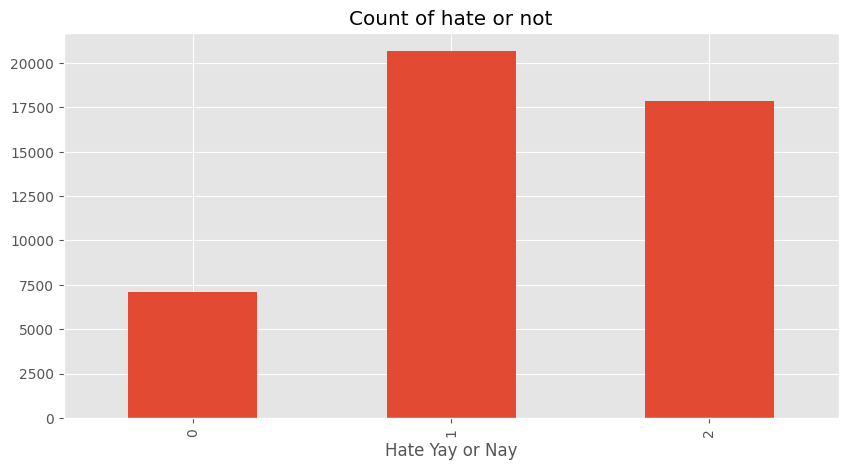

In [3]:
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of hate or not',
          figsize=(10, 5))
ax.set_xlabel('Hate Yay or Nay')
plt.show()

In [4]:
example = df['text'][random.randint(0, 500)]
print(example)

Going to be heading out tomorrow to check out the Earth Festival in Davis #ImNotAHippie


In [5]:
tokens = nltk.word_tokenize(example)
print(tokens[:10])


['Going', 'to', 'be', 'heading', 'out', 'tomorrow', 'to', 'check', 'out', 'the']


In [6]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Going', 'VBG'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('heading', 'VBG'),
 ('out', 'RB'),
 ('tomorrow', 'NN'),
 ('to', 'TO'),
 ('check', 'VB'),
 ('out', 'RP'),
 ('the', 'DT')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Going/VBG
  to/TO
  be/VB
  heading/VBG
  out/RB
  tomorrow/NN
  to/TO
  check/VB
  out/RP
  the/DT
  (ORGANIZATION Earth/NN Festival/NNP)
  in/IN
  (GPE Davis/NNP)
  #/#
  (ORGANIZATION ImNotAHippie/NNP))


Pre Processing


In [8]:
import string

import re

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import contractions


In [9]:
def remove_hyperlinks_marks_styles(text):
    new_text = re.sub(r'^RT[\s]', '', text)
    new_text = re.sub(r'@\S+', '', new_text)
    new_text = re.sub(r'https?:\/\/.*[\r\n]*','', new_text)
    new_text = re.sub(r'#', '', new_text)

    return new_text
    

In [10]:
def tokenize_text(text):

    text_tokens = nltk.word_tokenize(text)

    return text_tokens


In [11]:
nltk.download('stopwords')

stopwords_english = stopwords.words('english')

punctuations = string.punctuation

def remove_punctuations_stopwords(text_tokens):

    text_clean = []

    for word in text_tokens:
        if (word not in stopwords_english and word not in punctuations):
            text_clean.append(word)

    return text_clean


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RajBu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def expand_contractions_in_text(text):
    return contractions.fix(text)

In [13]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif nltk_tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif nltk_tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to noun

In [14]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text_tokens):
    pos_tags = pos_tag(text_tokens)  # POS tagging
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]


In [15]:
def preprocess_text(text):
    text = remove_hyperlinks_marks_styles(text)  # Remove unnecessary elements
    text = expand_contractions_in_text(text)
    tokens = tokenize_text(text)  # Tokenize
    tokens = remove_punctuations_stopwords(tokens)  # Remove stopwords & punctuation
    tokens = lemmatize_text(tokens)  # Lemmatize with POS tagging
    return " ".join(tokens)  # Convert back to string if needed

preprocessing example

In [16]:
text = df['text'][random.randint(0, 500)]
processed_text = preprocess_text(text)

print("Original:", text)
print("Processed:", processed_text)

Original: Who wants to be my date to the White Sox vs Red Sox game Tuesday
Processed: Who want date White Sox v Red Sox game Tuesday


preprocessing all datasets

In [17]:
train_data = pd.read_csv('sentiment_train.csv')
val_data = pd.read_csv('sentiment_validation.csv')
test_data = pd.read_csv('sentiment_test.csv')


X_train, y_train = train_data['text'], train_data['label']
X_val, y_val = val_data['text'], val_data['label']
X_test, y_test = test_data['text'], test_data['label']

In [18]:
# Ensure the text column is a string and handle NaNs
X_train = X_train.astype(str).fillna('')
X_val = X_val.astype(str).fillna('')
X_test = X_test.astype(str).fillna('')

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)


In [19]:
print(X_train)

0        `` QT In original draft 7th book Remus Lupin s...
1        `` Ben Smith Smith concussion remain lineup Th...
2        Sorry bout stream last night I crash tonight s...
3        Chase Headley 's RBI double 8th inning David P...
4        Alciato Bee invest 150 million January another...
                               ...                        
45610    '' '' So amazing beautiful Lady Gaga show AC t...
45611    9 September arrive mean Apple 's new iPhone ho...
45612    Leeds 1-1 Sheff Wed. Giuseppe Bellusci secure ...
45613    I hilton head till 8th lol go Jason aldean sep...
45614    WASHINGTON Reuters YOU.S Vice President Joe Bi...
Name: text, Length: 45615, dtype: object


Naive Bayes Model

Converting text into numerical features using TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.8) 


In [21]:
# Fit on training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform validation and test data
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_curve

converting labels to negative or non negative

In [23]:
y_train_binary = y_train.apply(lambda x: 1 if x == 0 else 0)  # 0 = negative (target), 1 & 2 = non-negative
y_val_binary = y_val.apply(lambda x: 1 if x == 0 else 0)
y_test_binary = y_test.apply(lambda x: 1 if x == 0 else 0)


In [24]:
model = MultinomialNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5,2.0, 5.0, 7.5, 10],  # Smoothing parameter
    'fit_prior': [True, False]      # Whether to learn class prior probabilities
}

# Track the best model and score
best_score = 0
best_params = {}


In [25]:
for alpha in param_grid['alpha']:
    for fit_prior in param_grid['fit_prior']:
        # Set model parameters
        model.set_params(alpha=alpha, fit_prior=fit_prior)
        
        # Train on the training set
        model.fit(X_train_tfidf, y_train_binary)
        
        # Evaluate on the validation set
        val_predictions = model.predict(X_val_tfidf)
        val_score = accuracy_score(y_val_binary, val_predictions)
        
        # Update best model if needed
        if val_score > best_score:
            best_score = val_score
            best_params = {'alpha': alpha, 'fit_prior': fit_prior}

print(f"Best Validation Accuracy: {best_score}")
print(f"Best Hyperparameters: {best_params}")

Best Validation Accuracy: 0.8565
Best Hyperparameters: {'alpha': 0.1, 'fit_prior': True}


In [26]:
# Evaluate on Test Set
y_test_pred = model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test_binary, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test_binary, y_test_pred))

cm = confusion_matrix(y_test_binary, y_test_pred)
print("Confusion Matrix:\n", cm)


f1 = f1_score(y_test_binary, y_test_pred)
print(f"F1 Score: {f1}")


Test Accuracy: 0.6769781830022794
Test Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.99      0.81      8312
           1       0.51      0.03      0.06      3972

    accuracy                           0.68     12284
   macro avg       0.59      0.51      0.43     12284
weighted avg       0.62      0.68      0.56     12284

Confusion Matrix:
 [[8198  114]
 [3854  118]]
F1 Score: 0.056137012369172214


Neural Network Model


preprocessing

In [27]:

def nn_preprocess_text(text, remove_stopwords=True):
    # Lowercase the text
    text = text.lower()
    
    # Remove hyperlinks etc.

    text = remove_hyperlinks_marks_styles(text)

    text = expand_contractions_in_text(text)

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    
    #Remove stopwords
    if remove_stopwords:
        text = ' '.join(word for word in text.split() if word not in stopwords_english)
    
    return text

In [28]:
text = df['text'][random.randint(0, 500)]
processed_text = nn_preprocess_text(text)

print("Original:", text)
print("Processed:", processed_text)

Original: O. Johnson commits his 3rd foul! He\u2019s cold off the bench with 3 fouls and a turnover in Q4. #Pacers losing 98-87\u002c 4:52 left.
Processed: johnson commits rd foul heus cold bench foul turnover q pacer losing uc left


inputs

In [29]:
import tensorflow as tf

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


In [31]:
nn_train_data = pd.read_csv('sentiment_train.csv')
nn_val_data = pd.read_csv('sentiment_validation.csv')
nn_test_data = pd.read_csv('sentiment_test.csv')


nn_X_train, nn_y_train = nn_train_data['text'], nn_train_data['label']
nn_X_val, nn_y_val = nn_val_data['text'], nn_val_data['label']
nn_X_test, nn_y_test = nn_test_data['text'], nn_test_data['label']

In [32]:
# Ensure the text column is a string and handle NaNs
nn_X_train = nn_X_train.astype(str).fillna('')
nn_X_val = nn_X_val.astype(str).fillna('')
nn_X_test = nn_X_test.astype(str).fillna('')

nn_X_train = nn_X_train.apply(nn_preprocess_text)
nn_X_val = nn_X_val.apply(nn_preprocess_text)
nn_X_test = nn_X_test.apply(nn_preprocess_text)

In [33]:
print(nn_X_train.head)

<bound method NDFrame.head of 0        qt original draft th book remus lupin survived...
1        ben smith smith concussion remains lineup thur...
2        sorry bout stream last night crashed tonight s...
3        chase headleys rbi double th inning david pric...
4        alciato bee invest million january another sum...
                               ...                        
45610    amazing beautiful lady gaga show ac tonight lo...
45611    september ha arrived mean apple new iphone hou...
45612    leeds sheff wed giuseppe bellusci securing luf...
45613    hilton head till th lol go jason aldean sept t...
45614    washington reuters yous vice president joe bid...
Name: text, Length: 45615, dtype: object>


In [34]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(nn_X_train)

nn_X_train_seq = tokenizer.texts_to_sequences(nn_X_train)
nn_X_val_seq = tokenizer.texts_to_sequences(nn_X_val)
nn_X_test_seq = tokenizer.texts_to_sequences(nn_X_test)

In [35]:
# Padding sequences
max_sequence_length = 100

nn_X_train_padded = pad_sequences(nn_X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
nn_X_val_padded = pad_sequences(nn_X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
nn_X_test_padded = pad_sequences(nn_X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')


converting labels to negative or non negative

In [36]:
nn_y_train_binary = nn_y_train.apply(lambda x: 1 if x == 0 else 0)  # 0 = negative (target), 1 & 2 = non-negative
nn_y_val_binary = nn_y_val.apply(lambda x: 1 if x == 0 else 0)
nn_y_test_binary = nn_y_test.apply(lambda x: 1 if x == 0 else 0)

In [37]:
# Build LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=100),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [38]:
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
]

In [39]:
# Train model
history = model.fit(nn_X_train_padded, nn_y_train_binary, validation_data=(nn_X_val_padded, nn_y_val_binary), epochs=10, batch_size=32, callbacks=callbacks, verbose=1)


Epoch 1/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8422 - loss: 0.4440

1426/1426 ━━━━━━━━━━━━━━━━━━━━ 156s 105ms/step - accuracy: 0.8422 - loss: 0.4440 - val_accuracy: 0.8440 - val_loss: 0.4333
Epoch 2/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 156s 110ms/step - accuracy: 0.8454 - loss: 0.4346 - val_accuracy: 0.8440 - val_loss: 0.4334
Epoch 3/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 160s 112ms/step - accuracy: 0.8423 - loss: 0.4396 - val_accuracy: 0.8440 - val_loss: 0.4331
Epoch 4/10
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 158s 111ms/step - accuracy: 0.8465 - loss: 0.4314 - val_accuracy: 0.8440 - val_loss: 0.4339
Epoch 4: early stopping


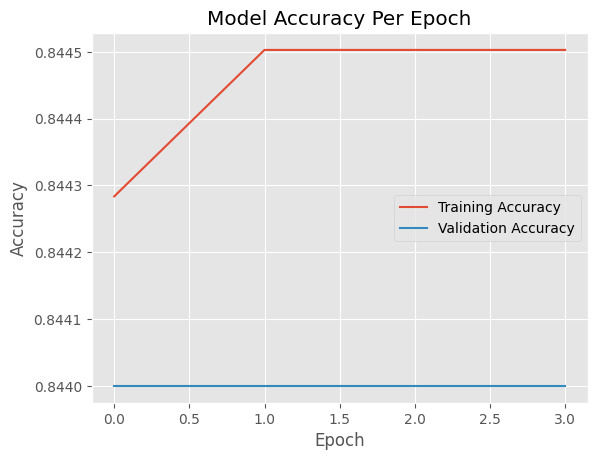

In [40]:
#plot accuracy per epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Per Epoch')
plt.legend()
plt.show()

In [41]:
# Evaluate model
nn_y_pred = (model.predict(nn_X_test_padded) > 0.5).astype('int32')
print(classification_report(nn_y_test_binary, nn_y_pred))
print(confusion_matrix(nn_y_test_binary, nn_y_pred))
print('Accuracy:', accuracy_score(nn_y_test_binary, nn_y_pred))

nn_f1 = f1_score(nn_y_test_binary, nn_y_pred)
print(f"F1 Score: {nn_f1}")

384/384 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      8312
           1       0.00      0.00      0.00      3972

    accuracy                           0.68     12284
   macro avg       0.34      0.50      0.40     12284
weighted avg       0.46      0.68      0.55     12284

[[8312    0]
 [3972    0]]
Accuracy: 0.6766525561706285
F1 Score: 0.0


C:\Users\RajBu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RajBu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\RajBu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Bert Transformer

imports

In [63]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset



In [64]:
bert_train_data = pd.read_csv('sentiment_train.csv')
bert_val_data = pd.read_csv('sentiment_validation.csv')
bert_test_data = pd.read_csv('sentiment_test.csv')


In [65]:
bert_train_data['label'] = bert_train_data['label'].apply(lambda x: 1 if x != 0 else 0)
bert_val_data['label'] = bert_val_data['label'].apply(lambda x: 1 if x != 0 else 0)
bert_test_data['label'] = bert_test_data['label'].apply(lambda x: 1 if x != 0 else 0)

In [66]:
bert_train_data.head(100)

,text,label
0,"""QT @user In the original draft of the 7th boo...",1
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,1
...,...,...
95,@user I\u2019m sick with something ill be at s...,0
96,"""There's something about Friday Night Lights, ...",1
97,Googled the snake I stepped over on the trail ...,1
98,"@user Also, his anger against Hindus are justi...",0


In [67]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [68]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

In [ ]:
bert_train_data = Dataset.from_pandas(bert_train_data)
bert_val_data = Dataset.from_pandas(bert_val_data)
bert_test_data = Dataset.from_pandas(bert_test_data)


AttributeError: 'Dataset' object has no attribute 'columns'

In [ ]:
bert_train_data = bert_train_data.map(tokenize_function, batched=True)
bert_val_data = bert_val_data.map(tokenize_function, batched=True)
bert_test_data = bert_test_data.map(tokenize_function, batched=True)

Map: 100%|██████████| 12284/12284 [00:06<00:00, 1755.38 examples/s]


In [ ]:
bert_train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
bert_val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
bert_test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # training epochs
    per_device_train_batch_size=16,   # batch size for training
    per_device_eval_batch_size=16,    # batch size for evaluation
    warmup_steps=500,                # warmup steps for learning rate scheduler
    weight_decay=0.01,               # weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [71]:
num_samples_to_take = 8600
ds = Dataset.from_pandas(bert_test_data, "en", split="train")
ds = ds.take(num_samples_to_take)

AttributeError: 'Dataset' object has no attribute 'columns'

In [ ]:
trainer = Trainer(
    model=model,                         # the model to train
    args=training_args,                  # training arguments
    train_dataset=bert_train_data,            # training dataset
    eval_dataset=bert_val_data,               # evaluation dataset
    tokenizer=tokenizer,                 # tokenizer
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.predictions.argmax(axis=1), p.label_ids)
    }
)

C:\Users\RajBu\AppData\Local\Temp\ipykernel_2072\1199333552.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
10,0.635400
20,0.563300
30,0.508100
40,0.490200
50,0.485400
60,0.399700
70,0.435300
80,0.384300
90,0.427400
100,0.438000


KeyboardInterrupt: 

In [ ]:
results = trainer.evaluate()
print(f"Results: {results}")

Results: {'eval_loss': 0.24607114493846893, 'eval_accuracy': 0.901, 'eval_runtime': 454.385, 'eval_samples_per_second': 4.402, 'eval_steps_per_second': 0.275, 'epoch': 1.0}


In [ ]:
predictions, labels, _ = trainer.predict(bert_test_data)
predictions = predictions.argmax(axis=1)

print(classification_report(labels, predictions))

KeyError: 0